<a href="https://colab.research.google.com/github/dbxmcf/node/blob/master/Copy_of_SimpleODEProblems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

In [0]:
!pip install --upgrade git+https://github.com/titu1994/tfdiffeq.git

  Cloning https://github.com/titu1994/tfdiffeq.git to /tmp/pip-req-build-s3ts860j
  Running command git clone -q https://github.com/titu1994/tfdiffeq.git /tmp/pip-req-build-s3ts860j
  Created wheel for tfdiffeq: filename=tfdiffeq-0.0.1-py2.py3-none-any.whl size=39100 sha256=96cefb239d368798320ec7bb6bcc18ccc258c127141cb3b02ff38e0093826b7d
  Stored in directory: /tmp/pip-ephem-wheel-cache-q5hmtl_6/wheels/1a/fc/26/608bd5ecbf21d23b0e87bb71814d3c031b7c8a5b37fa7aa904
Successfully built tfdiffeq


In [0]:
from tfdiffeq import odeint

## Some parameters

In [0]:
NUM_SAMPLES = 1000
device = 'cpu:0' # These experiments do not require the GPU. Normally, 'gpu:0' if tf.test.is_gpu_available() else 'cpu:0' should be used.

# Some useful plotting functions

In [0]:
from tfdiffeq import plot_phase_portrait, plot_vector_field, plot_results

# Solving a Second Order differential equation



## Transforming a Second Order ODE to a System of ODEs

Consider the same differential equation  as above

>$y'' - 5y' + 6y = 0$

As before, we must transform the equation by replacing variables.

Say $u = y$ and $v = y'$.

Then, we can take their derivatives to get : 

>$u' = y'$ and $v' = y''$

However, we see that $y' = v$, so we can substitute inplace as such.

Furthermore, lets look at the original equation after moving around the terms

>$y'' = 5y' - 6y$

We can substitute the above with the value for $v = y''$ as such.

So we can rewrite the two terms as : 

>$u' = v$

>$v' = 5y' - 6y$

We now need to bring these two equations in terms of just $u$ and $v$. So we replace the values of $y$ and $y'$.

>$v' = 5v - 6u$

Having reached here, we can simply keep the equation as above and solve for u and v directly !

## Lets define our initial states

As we now do not have a need for a state matrix, we can jump right to defining the initial values of $u$ and $v$.

Notice that we now define our initial states as **vector** of shape [2], not a **matrix** of shape [1, 2]

In [0]:
initial_states = tf.convert_to_tensor([1., 1.], dtype=tf.float64); initial_states

<tf.Tensor: id=0, shape=(2,), dtype=float64, numpy=array([1., 1.])>

## Once again, as we are differentiating wrt time $t$, we define it

In [0]:
t = tf.linspace(0., 1., num=NUM_SAMPLES); t.shape

TensorShape([Dimension(1000)])

## Defining a function to represent the ODE

Notice the difference in how this function accepts input as a vector, not a matrix, and returns a vector, not a matrix.

In [0]:
class Lambda(tf.keras.Model):
  
  def call(self, t, y):
    # y now reprents the a vector of [u, v]
    u, v = y[0], y[1]
    
    du_dt = v
    dv_dt = 5 * v - 6 * u
    
    return tf.stack([du_dt, dv_dt])  # vector of shape [2]

## Computing the Integral of a set of ODEs

In [0]:
%%time

with tf.device(device):
  result = odeint(Lambda(), initial_states, t)

print("Completed integration ! Output Shape =", result.shape)

Completed integration ! Output Shape = (1000, 2)
CPU times: user 982 ms, sys: 4.89 ms, total: 987 ms
Wall time: 1.07 s


## Plotting the results

(-2, 2)

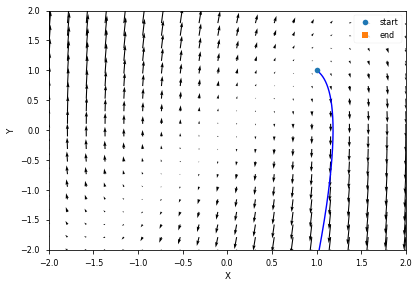

In [0]:
lims = [-2, 2]
plot_phase_portrait(Lambda(), xlims=lims, ylims=lims, ip_rank=1) # the function accepts a vector as input, so input rank is 1 by default.
plot_vector_field(result)
plt.xlim(lims)
plt.ylim(lims)

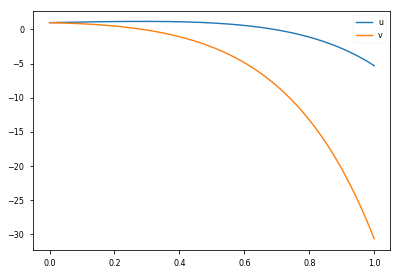

In [0]:
plot_results(t, result, labels=['u', 'v'])

# Some visually interesting ODEs

In [0]:
class OscilationCurve(tf.keras.Model):
  
  def call(self, t, y):
    dy_dt = tf.sin(t * t) * y
    return dy_dt

## Oscilatory Curve

>$y' = sin(t^2) * y ; \quad t \in [0, 8] \quad y(0) = 1$



In [0]:
t = tf.linspace(0., 8., num=NUM_SAMPLES)
initial_state = tf.convert_to_tensor(1., dtype=tf.float64)

In [0]:
%%time

with tf.device(device):
  result = odeint(OscilationCurve(), initial_state, t)
  
print("Finished integrating ! Result shape :", result.shape)

Finished integrating ! Result shape : (1000,)
CPU times: user 2.03 s, sys: 29 ms, total: 2.05 s
Wall time: 2.02 s


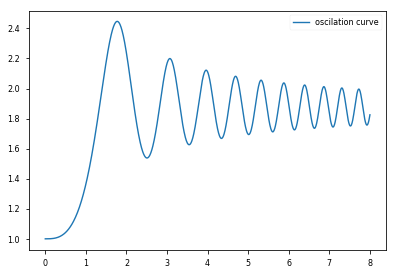

In [0]:
plot_results(t, result, labels='oscilation curve')

## Jagged Oscilation Curve

>$y' = sign(sin(t^2)) * y ; \quad t \in [0, 8] \quad y(0) = 1$

In [0]:
class JaggedOscilationCurve(tf.keras.Model):
  
  def call(self, t, y):
    dy_dt = tf.sign(tf.sin(t * t)) * y
    return dy_dt

In [0]:
t = tf.linspace(0., 8., num=NUM_SAMPLES)
initial_state = tf.convert_to_tensor(1., dtype=tf.float64)

In [0]:
%%time

with tf.device(device):
  result = odeint(JaggedOscilationCurve(), initial_state, t)
  
print("Finished integrating ! Result shape :", result.shape)

Finished integrating ! Result shape : (1000,)
CPU times: user 8.66 s, sys: 18 ms, total: 8.68 s
Wall time: 8.67 s


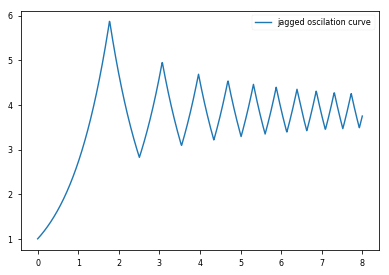

In [0]:
plot_results(t, result, labels='jagged oscilation curve')

## Oscilation with non linear damping

>$y' = 3 cos(t) - y^3 ; \quad t \in [0, 10] \quad y(0) = 0$


In [0]:
class NonLinearDamping(tf.keras.Model):
  
  def call(self, t, y):
    dy_dt = 3. * tf.cos(t) - tf.pow(y, 3)
    return dy_dt

In [0]:
t = tf.linspace(0., 20., num=NUM_SAMPLES)
initial_state = tf.convert_to_tensor(0., dtype=tf.float64)

In [0]:
%%time

with tf.device(device):
  result = odeint(NonLinearDamping(), initial_state, t)
  
print("Finished integrating ! Result shape :", result.shape)

Finished integrating ! Result shape : (1000,)
CPU times: user 3.67 s, sys: 25.7 ms, total: 3.7 s
Wall time: 3.69 s


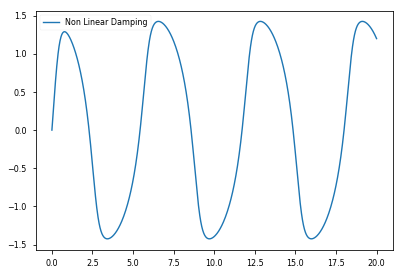

In [0]:
plot_results(t, result, labels='Non Linear Damping')

# Some visually interesting system of ODEs

## Predator - Prey System

>$\frac{dR}{dT} = aR - bRF \\ \frac{dF}{dT} = -cF + dRF$

In [0]:
class PredatorPrey(tf.keras.Model):
  
  def __init__(self, a, b, c, d, **kwargs):
    super().__init__(**kwargs)
    
    self.a, self.b, self.c, self.d = a, b, c, d
    
  def call(self, t, y):
    # y = [R, F]
    r, f = tf.unstack(y)
    
    dR_dT = self.a * r - self.b * r * f
    dF_dT = -self.c * f + self.d * r * f
    
    return tf.stack([dR_dT, dF_dT])

In [0]:
t = tf.linspace(0., 10., num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([1, 1], dtype=tf.float64)

In [0]:
a = 1.5
b = 1
c = 3
d = 1

In [0]:
%%time

with tf.device(device):
  result = odeint(PredatorPrey(a, b, c, d), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 2)
CPU times: user 2.19 s, sys: 10.4 ms, total: 2.2 s
Wall time: 2.21 s


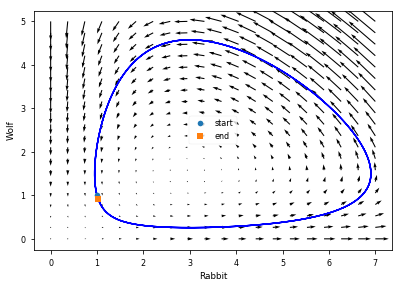

In [0]:
lims = [0, 5]
plot_phase_portrait(PredatorPrey(a, b, c, d), xlabel='Rabbit', ylabel='Wolf', xlims=[0, 7], ylims=lims)
plot_vector_field(result, xlabel='Rabbit', ylabel='Wolf')

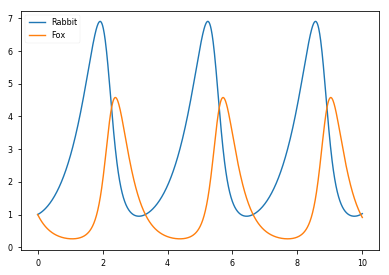

In [0]:
plot_results(t, result, labels=['Rabbit', 'Fox'])

## Limited Predator-Prey System

>$\frac{dR}{dT} =R(1 - R) - RF \\ \frac{dF}{dT} = -F + dRF$

In [0]:
class LimitedPredatorPrey(tf.keras.Model):
  
  def __init__(self, d, **kwargs):
    super().__init__(**kwargs)
    
    self.d = d
    
  def call(self, t, y):
    # y = [R, F]
    r, f = tf.unstack(y)
    
    dR_dT = r * (1. - r) - r * f
    dF_dT = -f + self.d * r * f
    
    return tf.stack([dR_dT, dF_dT])

In [0]:
t = tf.linspace(0., 20., num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([1, 1], dtype=tf.float64)

In [0]:
d = 2

In [0]:
%%time

with tf.device(device):
  result = odeint(LimitedPredatorPrey(d), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 2)
CPU times: user 1.33 s, sys: 7.23 ms, total: 1.33 s
Wall time: 1.34 s


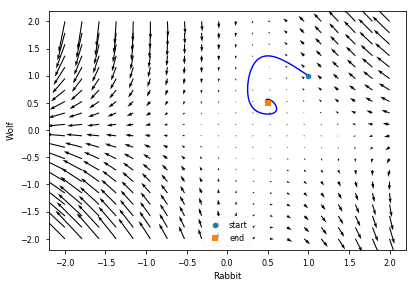

In [0]:
plot_phase_portrait(LimitedPredatorPrey(d), xlabel='Rabbit', ylabel='Wolf')
plot_vector_field(result, xlabel='Rabbit', ylabel='Wolf')

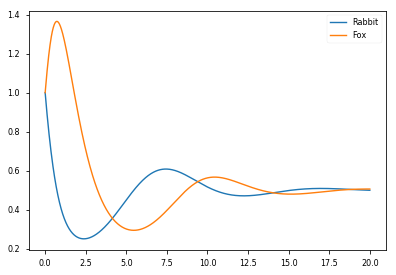

In [0]:
plot_results(t, result, labels=['Rabbit', 'Fox'])

## Periodic Sinusodial ODE

>$\frac{dx}{dt} = x (1 - \sqrt{x^2 + y^2})) - y$

>$\frac{dy}{dt} = x + y  (1 - \sqrt{x^2 + y^2})) $

In [0]:
class PeriodicSinusodial(tf.keras.Model):
  
  def call(self, t, v):
    # v = [x, y]
    x, y = tf.unstack(v)
    
    xy = tf.sqrt(x * x + y * y)
    dx_dt = x * (1 - xy) - y
    dy_dt = x + y * (1 - xy)
    
    return tf.stack([dx_dt, dy_dt])

In [0]:
t = tf.linspace(0., 10., num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([1, 1], dtype=tf.float64)

In [0]:
%%time

with tf.device(device):
  result = odeint(PeriodicSinusodial(), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 2)
CPU times: user 1.45 s, sys: 22.2 ms, total: 1.47 s
Wall time: 1.45 s


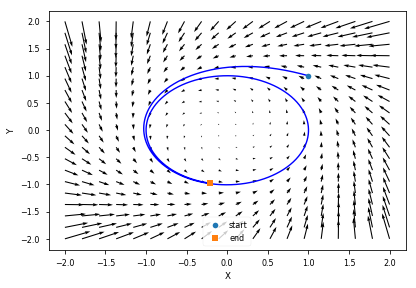

In [0]:
plot_phase_portrait(PeriodicSinusodial(), xlabel='X', ylabel='Y')
plot_vector_field(result, xlabel='X', ylabel='Y')

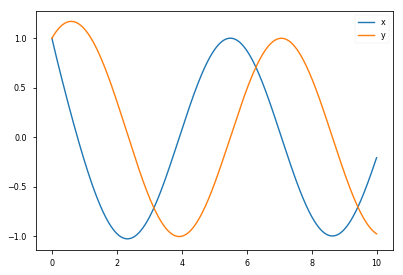

In [0]:
plot_results(t, result, labels=['x', 'y'])

## Plotting many initial states at once

In [0]:
t = tf.linspace(0., 10., num=NUM_SAMPLES)

In [0]:
state_list = [[2., 2.], [2., 0.], [0., 2.], [0., 0.],
              [-2., -2.], [-2., 0.], [0., -2.]]

initial_state_list = [tf.convert_to_tensor(init_state, dtype=tf.float64)
                     for init_state in state_list]

## Computing all of the results

In [0]:
%%time

with tf.device(device):
  result_list = [odeint(PeriodicSinusodial(), init_state, t)
                 for init_state in initial_state_list]
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 2)
CPU times: user 9.51 s, sys: 28.7 ms, total: 9.54 s
Wall time: 9.51 s


## Plotting all of the *results*

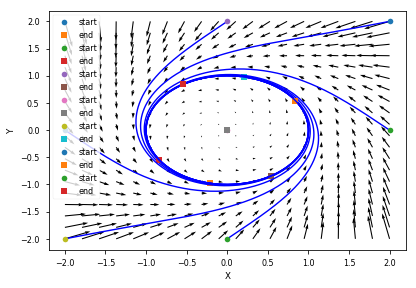

In [0]:
plot_phase_portrait(PeriodicSinusodial(), xlabel='X', ylabel='Y')

for result in result_list:
  plot_vector_field(result, xlabel='X', ylabel='Y')

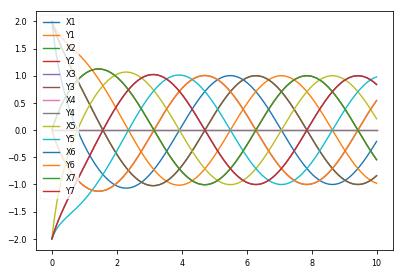

In [0]:
for i, result in enumerate(result_list):
  plot_results(t, result, labels=['X%d' % (i + 1), 'Y%d' % (i + 1)])

# Interesting Linear Systems of ODE

Linear system of ODE can be represented in the form:

> $Y' = AY$ where $A = \begin{bmatrix} 
a & b \\
c & d \end{bmatrix}$ and $Y$ = $\begin{bmatrix} 
y_1 (t) \\
y_2 (t)
\end{bmatrix}$

## Consider the following (Page 107)

> $A = \begin{bmatrix}
-1 & 0 \\
1 & -2
\end{bmatrix}$ 

Therefore, upon solving, we should get 

> $Y$ = $\begin{bmatrix}
k_1 e^{(-t)} \\
k_2 e^{(-2t)}
\end{bmatrix}$

In [0]:
class LinearODE1(tf.keras.Model):
  
  def __init__(self, system, **kwargs):
    super().__init__(**kwargs)
    
    self.system = system
  
  def call(self, t, v):
    # v = [y1, y2]
    out = tf.matmul(v, self.system)  # returns [1, 2]
    return out

In [0]:
system = tf.convert_to_tensor([[-1, 0], [1, -2]], dtype=tf.float64)

In [0]:
t = tf.linspace(0., 10., num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([[1, 1]], dtype=tf.float64)

In [0]:
%%time

with tf.device(device):
  result = odeint(LinearODE1(system), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 1, 2)
CPU times: user 1.27 s, sys: 1.3 ms, total: 1.27 s
Wall time: 1.28 s


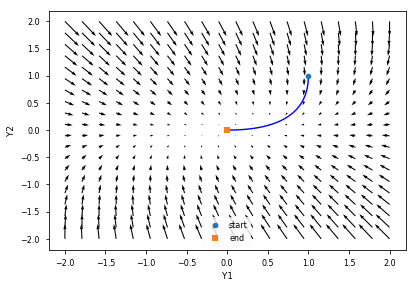

In [0]:
plot_phase_portrait(LinearODE1(system), xlabel='Y1', ylabel='Y2', ip_rank=2)
plot_vector_field(result, xlabel='Y1', ylabel='Y2')

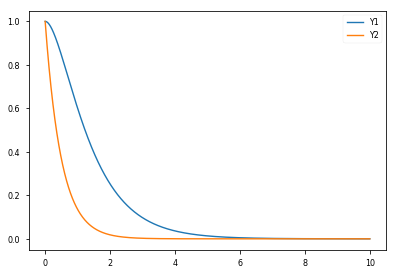

In [0]:
plot_results(t, result, labels=['Y1', 'Y2'])

## Linear ODE 2 (Page 108) - Stable Spiral


> $A = \begin{bmatrix}
0 & -1 \\
1 & 0
\end{bmatrix}$

Then the solution should be : 

> $Y$ = $\begin{bmatrix}
c \: cos{(t)} \\
c \: sin{(t)}
\end{bmatrix}$

In [0]:
system = tf.convert_to_tensor([[0, -1], [1, 0]], dtype=tf.float64)

In [0]:
t = tf.linspace(-np.pi, np.pi, num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([[1, 1]], dtype=tf.float64)

In [0]:
%%time

with tf.device(device):
  result = odeint(LinearODE1(system), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 1, 2)
CPU times: user 1.1 s, sys: 35.4 ms, total: 1.13 s
Wall time: 1.11 s


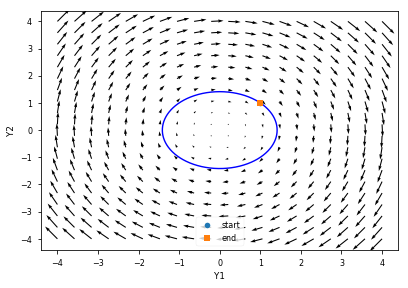

In [0]:
plot_phase_portrait(LinearODE1(system), xlabel='Y1', ylabel='Y2', ip_rank=2, xlims=[-4, 4], ylims=[-4, 4])
plot_vector_field(result, xlabel='Y1', ylabel='Y2')

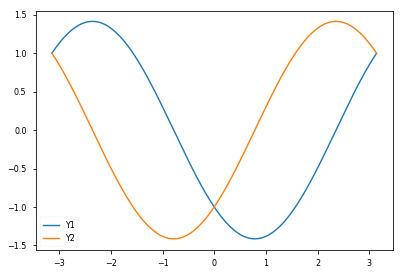

In [0]:
plot_results(t, result, labels=['Y1', 'Y2'])

## Linear ODE 3 (Page 109) - Spiral towards origin

> $A = \begin{bmatrix}
-0.1 & -1 \\
1 & -0.1
\end{bmatrix}$

Then the solution should be : 

> $Y$ = $ c \: e^{-0.1t} \begin{bmatrix}
c \: cos{(t)} \\
c \: sin{(t)}
\end{bmatrix}$

In [0]:
system = tf.convert_to_tensor([[-0.1, -1], [1, -0.1]], dtype=tf.float64)

In [0]:
t = tf.linspace(0., 25, num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([[1, 1]], dtype=tf.float64)

In [0]:
%%time

with tf.device(device):
  result = odeint(LinearODE1(system), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 1, 2)
CPU times: user 2.06 s, sys: 19.9 ms, total: 2.08 s
Wall time: 2.06 s


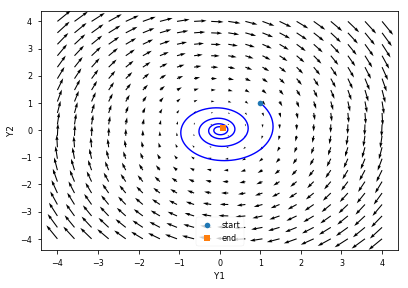

In [0]:
plot_phase_portrait(LinearODE1(system), xlabel='Y1', ylabel='Y2', ip_rank=2, xlims=[-4, 4], ylims=[-4, 4])
plot_vector_field(result, xlabel='Y1', ylabel='Y2')

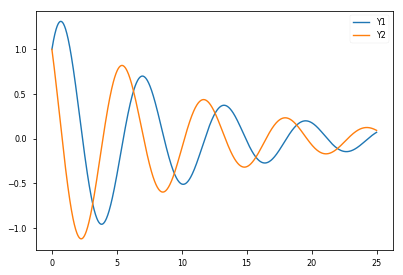

In [0]:
plot_results(t, result, labels=['Y1', 'Y2'])

## Complex Linear system (Pg 132)

> $A = \begin{bmatrix}
0 & 1 \\
0 & -1
\end{bmatrix}$

Then the solution should be : 

> $Y$ = $ k_1 \: e^{-t} \begin{bmatrix}
{-1} \\
{1}
\end{bmatrix} + k_2  \begin{bmatrix}
1 \\
0
\end{bmatrix}$

In [0]:
system = tf.convert_to_tensor([[0, 1], [0, -1]], dtype=tf.float64)

In [0]:
t = tf.linspace(0., 5, num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([[0, -1]], dtype=tf.float64)

In [0]:
%%time

with tf.device(device):
  result = odeint(LinearODE1(system), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 1, 2)
CPU times: user 1 s, sys: 22.5 ms, total: 1.03 s
Wall time: 1.01 s


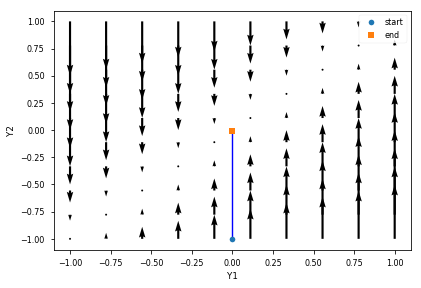

In [0]:
plot_phase_portrait(LinearODE1(system), xlabel='Y1', ylabel='Y2', ip_rank=2, xlims=[-1, 1], ylims=[-1, 1], num_points=10)
plot_vector_field(result, xlabel='Y1', ylabel='Y2')

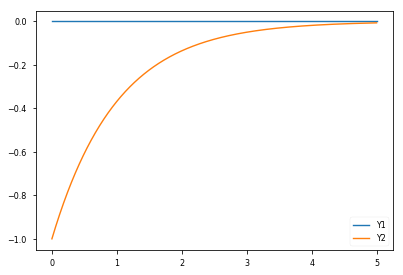

In [0]:
plot_results(t, result, labels=['Y1', 'Y2'])

## Complex Linear system (Pg 133)

> $A = \begin{bmatrix}
1 & 0 \\
-1 & b
\end{bmatrix}$


In [0]:
b = 0.5  # make positive of negative values
system = tf.convert_to_tensor([[1, 0], [1, b]], dtype=tf.float64)

In [0]:
t = tf.linspace(0., 5, num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([[0, 0.1]], dtype=tf.float64)

In [0]:
%%time

with tf.device(device):
  result = odeint(LinearODE1(system), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 1, 2)
CPU times: user 1.03 s, sys: 21.7 ms, total: 1.06 s
Wall time: 1.04 s


(-2.0, 2.0)

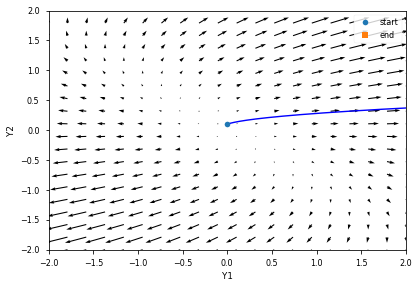

In [0]:
plot_phase_portrait(LinearODE1(system), xlabel='Y1', ylabel='Y2', ip_rank=2)
plot_vector_field(result, xlabel='Y1', ylabel='Y2')
plt.xlim([-2., 2.])
plt.ylim([-2., 2.])

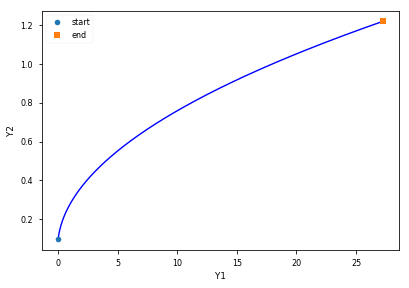

In [0]:
plot_vector_field(result, xlabel='Y1', ylabel='Y2')

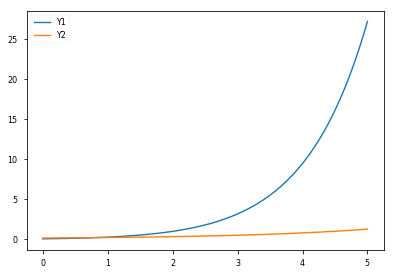

In [0]:
plot_results(t, result, labels=['Y1', 'Y2'])

# Non linear system of ODEs


## Parabolic System

> $x' = y - x^2 \\ y' = 1 - y$

In [0]:
class ParabolicSystem(tf.keras.Model):
  
  def call(self, t, v):
    # v = [x, y]
    x, y = tf.unstack(v)
    
    dx_dt = y - x * x
    dy_dt = 1 - y
    
    return tf.stack([dx_dt, dy_dt])

In [0]:
t = tf.linspace(0., 25, num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([-0.2, 0.2], dtype=tf.float64)

In [0]:
%%time

with tf.device(device):
  result = odeint(ParabolicSystem(), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 2)
CPU times: user 1.28 s, sys: 24.5 ms, total: 1.3 s
Wall time: 1.28 s


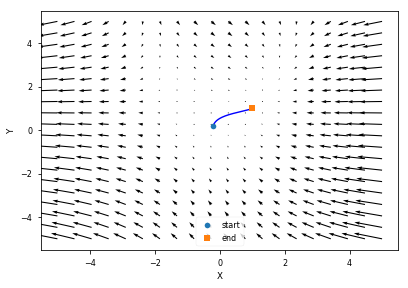

In [0]:
plot_phase_portrait(ParabolicSystem(), xlims=[-5, 5], ylims=[-5, 5])
plot_vector_field(result)

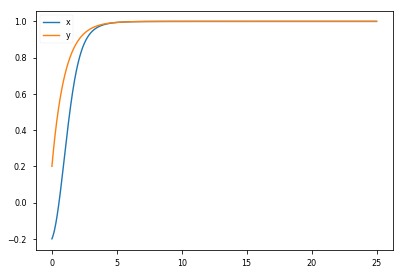

In [0]:
plot_results(t, result, labels=['x', 'y'])

## Tilted Parabolic System

> $x' = x ( 1 - x) \\ y' = x - y^2$

In [0]:
class NonLinearSystem1(tf.keras.Model):
  
  def call(self, t, v):
    # v = [x, y]
    x, y = tf.unstack(v)
    
    dx_dt = x * (1 - x)
    dy_dt = x - y * y
    
    return tf.stack([dx_dt, dy_dt])

In [0]:
t = tf.linspace(0., 10, num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([0.1, 0.0], dtype=tf.float64)

In [0]:
%%time

with tf.device(device):
  result = odeint(NonLinearSystem1(), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 2)
CPU times: user 1.11 s, sys: 25.2 ms, total: 1.14 s
Wall time: 1.12 s


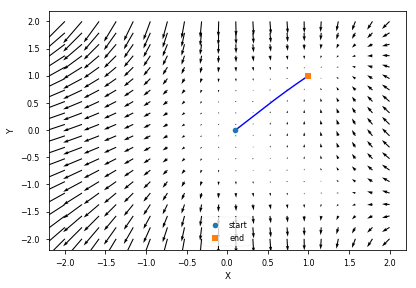

In [0]:
plot_phase_portrait(NonLinearSystem1())
plot_vector_field(result)

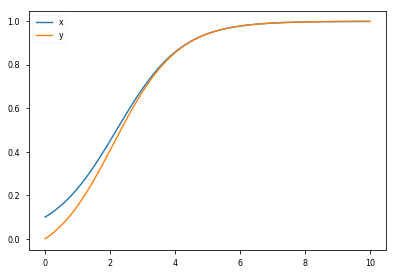

In [0]:
plot_results(t, result, labels=['x', 'y'])

## Predator-Prey as a Non Linear System

> $x' = x(1 - x) + A xy \\ y' = y (1 - y) + xy$

where $A$ is a positive parameter

In [0]:
class NonLinearSystemPredatorPrey(tf.keras.Model):
  
  def __init__(self, A, **kwargs):
    super().__init__(**kwargs)
    
    self.A = A
  
  def call(self, t, v):
    # v = [x, y]
    x, y = tf.unstack(v)
    
    dx_dt = x * (1 - x) + self.A * x * y
    dy_dt = y * (1 - y) + x * y
    
    return tf.stack([dx_dt, dy_dt])

In [0]:
A = 0.33

In [0]:
t = tf.linspace(0., 20, num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([2.0, 1.0], dtype=tf.float64)

In [0]:
%%time

with tf.device(device):
  result = odeint(NonLinearSystemPredatorPrey(A), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 2)
CPU times: user 1.35 s, sys: 5.22 ms, total: 1.35 s
Wall time: 1.35 s


(-4, 4)

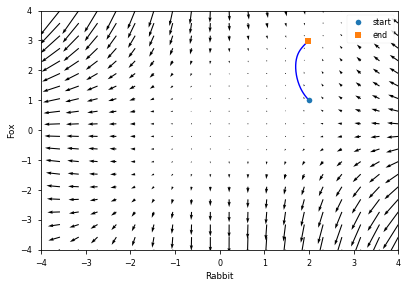

In [0]:
lims = [-4, 4]
plot_phase_portrait(NonLinearSystemPredatorPrey(A), xlabel='Rabbit', ylabel='Fox', xlims=lims, ylims=lims)
plot_vector_field(result, xlabel='Rabbit', ylabel='Fox')
plt.xlim(lims)
plt.ylim(lims)

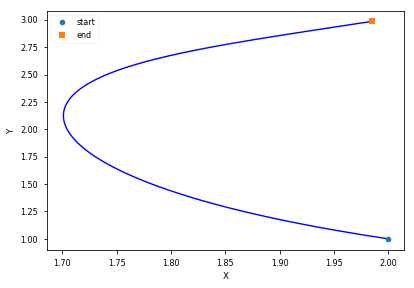

In [0]:
plot_vector_field(result)

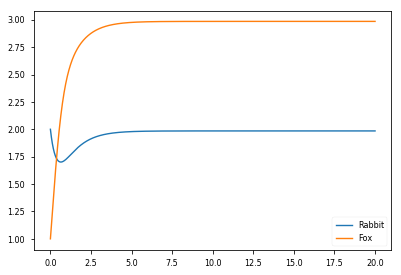

In [0]:
plot_results(t, result, labels=['Rabbit', 'Fox'])

# Using Jacobbian Linearization 

## Spiral Sink 

> $x' = y + x(x^2 + y^2) \\ y' = -x + y(x^2 + y^2)$



In [0]:
class SpiralSink(tf.keras.Model):
  
   def call(self, t, v):
    # v = [x, y]
    x, y = tf.unstack(v)
    
    dx_dt = y + x * (x * x + y * y)
    dy_dt = -x + y * (x * x + y * y)
    
    return tf.stack([dx_dt, dy_dt])

In [0]:
t = tf.linspace(0., 1, num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([0.5, 0.5], dtype=tf.float64)

In [0]:
%%time

with tf.device(device):
  result = odeint(SpiralSink(), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 2)
CPU times: user 2.65 s, sys: 17.8 ms, total: 2.67 s
Wall time: 2.65 s


(-5, 5)

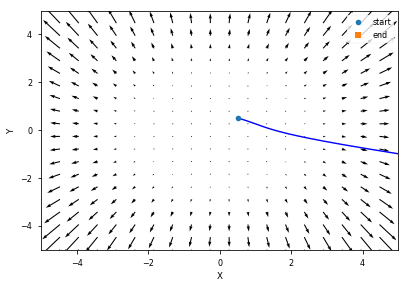

In [0]:
lims = [-5, 5]
plot_phase_portrait(SpiralSink(), xlims=lims, ylims=lims)
plot_vector_field(result)
plt.xlim(lims)
plt.ylim(lims)

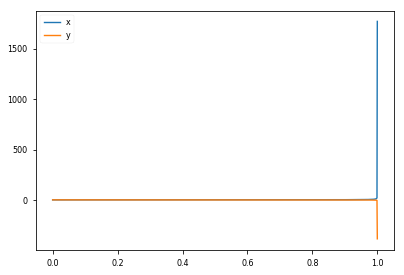

In [0]:
plot_results(t, result, labels=['x', 'y'])

## Jacobbian with Spiral Sink

Jacobbian matrix of the above spiral ODE
> $x' = y + x(x^2 + y^2) = F(x, y) \\ y' = -x + y(x^2 + y^2) = G(x, y)$

can be given by the partial derivatives of $F$ and $G$ wrt $x$ and $y$. 

> $J = \begin{bmatrix}
\frac{\partial{F}}{\partial{x}} & \frac{\partial{F}}{\partial{y}} \\
\frac{\partial{G}}{\partial{x}} & \frac{\partial{G}}{\partial{y}}
\end{bmatrix}$

This gives us the Jacobbian matrix of : 
> $J = \begin{bmatrix}
3x^2 + y^2 & 1 + 2xy \\
-1 + 2xy & x^2 + 3y^2
\end{bmatrix}$

At the origin point, $(x, y) = (0, 0)$,

> $J = \begin{bmatrix}
0 & -1 \\
1 & 0
\end{bmatrix}$

Now we linearize $Y'$ as 

> $Y' = J Y$

In [0]:
class JacobbianSpiralSink(tf.keras.Model):
  
   def __init__(self, J, **kwargs):
      super().__init__(self, **kwargs)
      
      self.J = J
  
   def call(self, t, v):
    # v = [x, y]
    x, y = v[0, 0], v[0, 1]
    
    dx_dt = y + x * (x * x + y * y)
    dy_dt = -x + y * (x * x + y * y)
    
    dv = tf.stack([dx_dt, dy_dt])
    dv = tf.reshape(dv, [1, -1])
    
    out = tf.matmul(dv, self.J)
    return out

In [0]:
J = tf.convert_to_tensor([[0, 1], [-1, 0]], dtype=tf.float64)

In [0]:
t = tf.linspace(0., 2, num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([[1, 1]], dtype=tf.float64)

In [0]:
%%time

with tf.device(device):
  result = odeint(JacobbianSpiralSink(J), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 1, 2)
CPU times: user 7.26 s, sys: 5.13 ms, total: 7.27 s
Wall time: 7.27 s


(-12, 12)

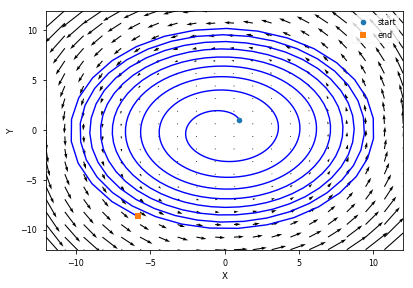

In [0]:
lims = [-12, 12]
plot_phase_portrait(JacobbianSpiralSink(J), xlims=lims, ylims=lims, ip_rank=2)
plot_vector_field(result)
plt.xlim(lims)
plt.ylim(lims)

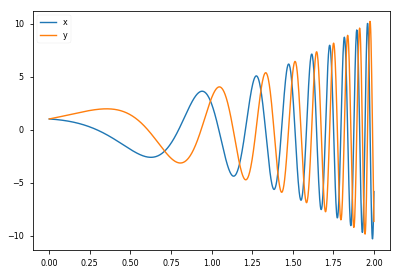

In [0]:
plot_results(t, result, labels=['x', 'y'])

## Jaccobian with Predator-Prey systems (Pg 159)

A non linear predator-prey system can also be written as :

> $x' = x(1 - x) - xy = F(x, y) \\ y' = -y + axy$

where $a > 1$ determines the equilibrium point at $(1/a, (a - 1) / a)$.

The Jacobbian of the above system can be given as :

> $J = \begin{bmatrix}
\frac{\partial{F}}{\partial{x}} & \frac{\partial{F}}{\partial{y}} \\
\frac{\partial{G}}{\partial{x}} & \frac{\partial{G}}{\partial{y}}
\end{bmatrix}$

This gives us the Jacobbian matrix :

> $J = \begin{bmatrix}
1 - 2x + y & -x \\
ay & -1 + ax
\end{bmatrix}$

At the equilibrium point, this Jacobbian becomes : 

> $J = \begin{bmatrix}
-1 / a & -1 / a \\
a - 1 & 0
\end{bmatrix}$

The charecteristic equation for the linearized system $Y' = JY$ is 

> $\lambda^2 + \lambda / a + (a - 1) / a = 0$

The corresponding eigenvalues are : 

> $1/2a \, (-1 \pm \sqrt{1 + 4a(1 - a)})$

The two cases are $a > 2 + 2\sqrt{2}$ and $1 < a < 2 + 2\sqrt{2}$

In [0]:
class JacobbianNonLinearSystemPredatorPrey(tf.keras.Model):
  
  def __init__(self, A, **kwargs):
    super().__init__(**kwargs)
    
    self.A = A
  
  def call(self, t, v):
    # v = [x, y]    
    x, y = tf.unstack(v)
    
    dx_dt = x * (1 - x) - x * y
    dy_dt = -y + self.A * x * y
    
    return tf.stack([dx_dt, dy_dt])

In [0]:
A = 5  # > 2 + 2 * 1.414

In [0]:
t = tf.linspace(0., 1, num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([5.0, 2.5], dtype=tf.float64)

In [0]:
%%time

with tf.device(device):
  result = odeint(JacobbianNonLinearSystemPredatorPrey(A), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 2)
CPU times: user 1.18 s, sys: 5.12 ms, total: 1.19 s
Wall time: 1.2 s


(-20, 20)

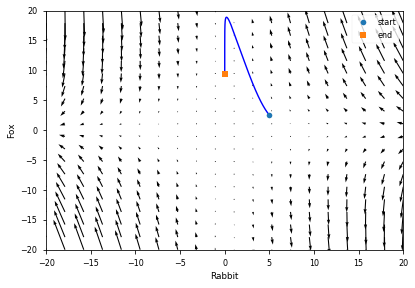

In [0]:
lims = [-20, 20]
plot_phase_portrait(JacobbianNonLinearSystemPredatorPrey(A), xlabel='Rabbit', ylabel='Fox', xlims=lims, ylims=lims)
plot_vector_field(result, xlabel='Rabbit', ylabel='Fox')
plt.xlim(lims)
plt.ylim(lims)

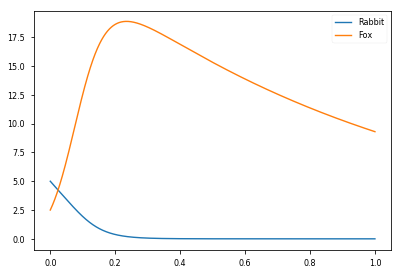

In [0]:
plot_results(t, result, labels=['Rabbit', 'Fox'])

# Limit Cycles

## Spiral Cycle

> $x' = -y + x (1 - (x^2 + y^2)) \\ y' = x + y(1 - (x^2 + y^2))$

In [0]:
class SpiralCycle(tf.keras.Model):
  
  def call(self, t, v):
    # v = [x, y]
    
    x, y = tf.unstack(v)
    sq = x * x + y * y
    
    dx_dt = -y + x * (1 - sq)
    dy_dt = x + y * (1 - sq)
    
    return tf.stack([dx_dt, dy_dt])

In [0]:
t = tf.linspace(0., 20, num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([2.0, 2.0], dtype=tf.float64)

In [0]:
%%time

with tf.device(device):
  result = odeint(SpiralCycle(), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 2)
CPU times: user 2.3 s, sys: 18.1 ms, total: 2.31 s
Wall time: 2.3 s


(-3, 3)

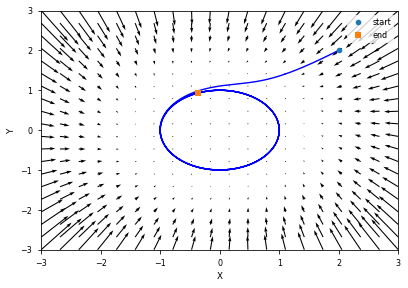

In [0]:
lims = [-3, 3]
plot_phase_portrait(SpiralCycle(), xlims=lims, ylims=lims)
plot_vector_field(result)
plt.xlim(lims)
plt.ylim(lims)

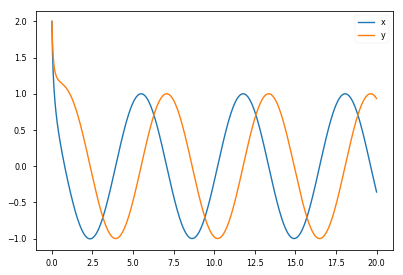

In [0]:
plot_results(t, result, labels=['x', 'y'])

# Chaotic Systems

## Undampened Pendulum with periodic force

> $\theta' = v \\ v' = -bv -g sin(\theta) -F cos(\omega t) sin(\theta)$

where $F$ measures how far we push the pendulum and $2\pi / \omega$ is the period of forcing.

In [0]:
class ForcePendulum(tf.keras.Model):
  
  def __init__(self, b, g, F, omega, **kwargs):
    super().__init__(**kwargs)
    
    self.b = b
    self.g = g
    self.F = F
    self.omega = omega
    
  def call(self, t, y):
    # y = [theta, v]    
    theta, v = tf.unstack(y)
    
    dtheta_dt = v
    dv_dt = -self.b * v - self.g * tf.sin(theta) - self.F * tf.cos(self.omega * t) * tf.sin(theta)
    
    return tf.stack([dtheta_dt, dv_dt])
    

In [0]:
b = 1.
g = 9.8
F = 1.
omega = np.pi / 2

In [0]:
t = tf.linspace(0., 25, num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([np.pi, 0.], dtype=tf.float64)

In [0]:
%%time

with tf.device(device):
  result = odeint(ForcePendulum(b, g, F, omega), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 2)
CPU times: user 2.52 s, sys: 624 µs, total: 2.52 s
Wall time: 2.53 s


(-4, 4)

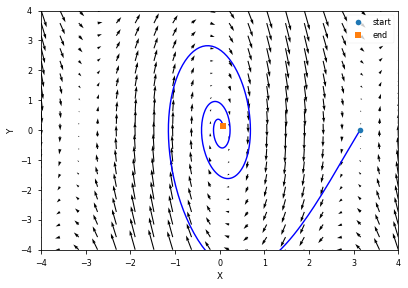

In [0]:
lims = [-4, 4]
plot_phase_portrait(ForcePendulum(b, g, F, omega), xlims=lims, ylims=lims)
plot_vector_field(result)
plt.xlim(lims)
plt.ylim(lims)

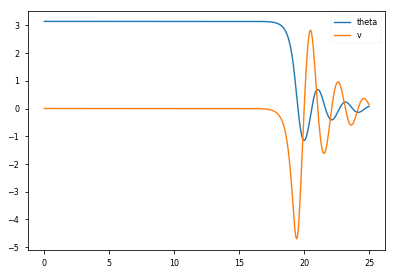

In [0]:
plot_results(t, result, labels=['theta', 'v'])

## Duffing Oscilator

> $y' = v \\ v' = y - y^3$

In [0]:
class DuffingOscilator(tf.keras.Model):
  
  def call(self, t, x):
    # x = [y, v]    
    y, v = tf.unstack(x)
    
    dy_dt = v
    dv_dt = y - tf.pow(y, 3)
    
    return tf.stack([dy_dt, dv_dt])
    

In [0]:
t = tf.linspace(0., 25, num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([-1, 1], dtype=tf.float64)

In [0]:
%%time

with tf.device(device):
  result = odeint(DuffingOscilator(), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 2)
CPU times: user 3.09 s, sys: 7.41 ms, total: 3.09 s
Wall time: 3.09 s


(-4, 4)

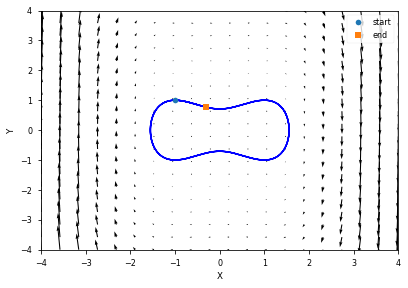

In [0]:
lims = [-4, 4]
plot_phase_portrait(DuffingOscilator(), xlims=lims, ylims=lims)
plot_vector_field(result)
plt.xlim(lims)
plt.ylim(lims)

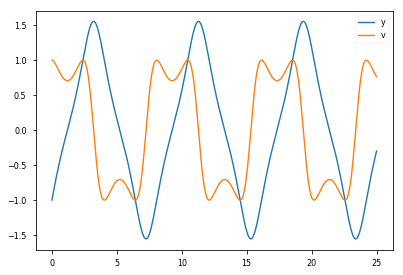

In [0]:
plot_results(t, result, labels=['y', 'v'])

## Lorenz Attractor

> $x' = \sigma(y - x) \\ y' = x (\rho - z) - y \\ z' = xy - \beta z$


In [0]:
class Lorenz(tf.keras.Model):

    def __init__(self, sigma=10., beta=8 / 3., rho=28., **kwargs):
        super().__init__(**kwargs)

        self.sigma = float(sigma)
        self.beta = float(beta)
        self.rho = float(rho)

    def call(self, t, y):
        """ y here is [x, y, z] """
        x, y, z = tf.unstack(y)
        
        dx_dt = self.sigma * (y - x)
        dy_dt = x * (self.rho - z) - y
        dz_dt = x * y - self.beta * z

        dL_dt = tf.stack([dx_dt, dy_dt, dz_dt])
        return dL_dt


In [0]:
sigma = 10.
beta = 8. / 3.
rho = 28.

In [0]:
t = tf.range(0.0, 100.0, 0.01, dtype=tf.float64)
initial_states = tf.convert_to_tensor([1., 1., 1.], dtype=tf.float64)

In [0]:
%%time

with tf.device(device):
  result = odeint(Lorenz(sigma, beta, rho), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (10000, 3)
CPU times: user 1min 4s, sys: 0 ns, total: 1min 4s
Wall time: 1min 4s


Text(0.5, 0.92, 'Lorenz Attractor')

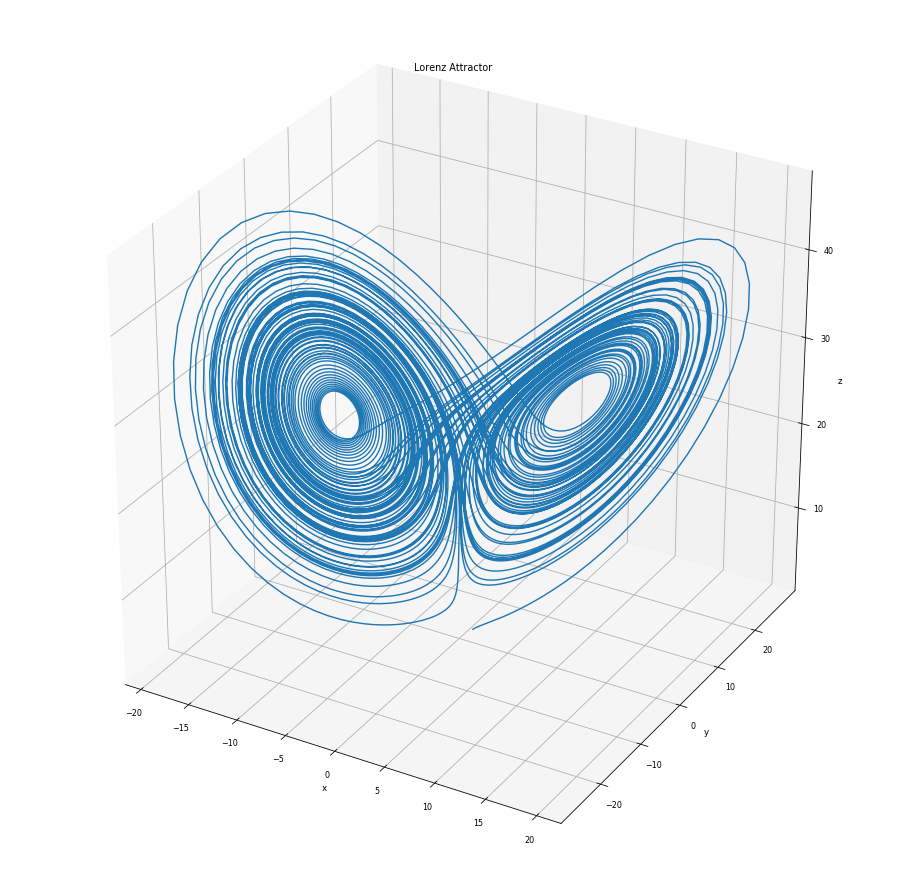

In [0]:
plot_results(t, result, labels=['x', 'y', 'z'], dependent_vars=True, figsize=(16, 16))
plt.title('Lorenz Attractor')

## Rossler System

> $x' = -y - z \\ y' = x + y/4 \\ z' = 1 + z(x - c)$

where $0 < c \le 7$

In [0]:
class Rossler(tf.keras.Model):

    def __init__(self, c, **kwargs):
        super().__init__(**kwargs)

        self.c = float(c)

    def call(self, t, v):
        """ v here is [x, y, z] """        
        x, y, z = tf.unstack(v)
        
        dx_dt = -y - z
        dy_dt =x + y/4
        dz_dt = 1 + z * (x - self.c)

        dL_dt = tf.stack([dx_dt, dy_dt, dz_dt])
        return dL_dt

In [0]:
c = 0.01

In [0]:
t = tf.range(0.0, 25.0, 0.01, dtype=tf.float64)
initial_states = tf.convert_to_tensor([1., 1., 1.], dtype=tf.float64)

In [0]:
%%time

with tf.device(device):
  result = odeint(Rossler(c), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (2500, 3)
CPU times: user 10.6 s, sys: 1.03 ms, total: 10.6 s
Wall time: 10.6 s


Text(0.5, 0.92, 'Rossler System')

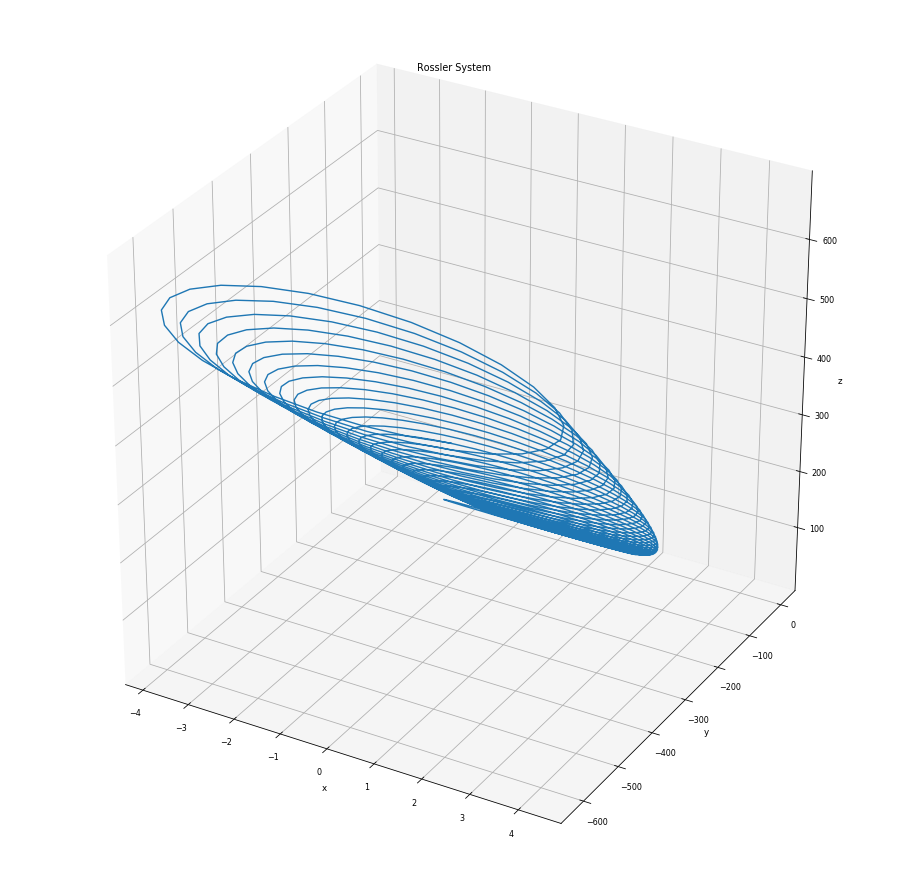

In [0]:
plot_results(t, result, labels=['x', 'y', 'z'], dependent_vars=True, figsize=(16, 16))
plt.title('Rossler System')